In [2]:
import torch
print(torch.__version__)

2.5.1


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Load dataset
df = pd.read_csv("market.csv")

# Keep only numeric columns (ignore Date, Symbol, etc.)
df_numeric = df.select_dtypes(include=["number"])

print("Numeric columns kept:", df_numeric.columns)

# Drop rows with missing values
df_numeric = df_numeric.dropna()

# Separate features and target (last column as target)
from sklearn.preprocessing import StandardScaler

# Scale features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df_numeric.drop(columns=["Close"]))


# Scale target
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_numeric["Close"].values.reshape(-1, 1))

# Convert to tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Wrap in dataset
dataset = TensorDataset(X, y)
print("Dataset size:", len(dataset))

# Print first 5 samples
for i in range(5):
    features, target = dataset[i]
    print(f"Sample {i}: X={features.numpy()}, y={target.numpy()}")
# Show first 5 actual vs scaled target values
raw_close = df_numeric["Close"].values[:5]
scaled_close = y[:5].numpy().flatten()

print("Original Close vs Scaled Close:")
for orig, scaled in zip(raw_close, scaled_close):
    print(f"Original: {orig:.4f}, Scaled: {scaled:.4f}")




Numeric columns kept: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
X shape: torch.Size([110238, 5])
y shape: torch.Size([110238, 1])
Dataset size: 110238
Sample 0: X=[-0.79129237 -0.7915447  -0.7906776  -0.7911522  -0.29521298], y=[-0.79117477]
Sample 1: X=[-0.7914566  -0.79170793 -0.79084283 -0.7913164  -0.29521298], y=[-0.791339]
Sample 2: X=[-0.79138666 -0.79163843 -0.7907725  -0.7912465  -0.29521298], y=[-0.79126906]
Sample 3: X=[-0.7910227  -0.7912767  -0.7904062  -0.7908825  -0.29521298], y=[-0.7909051]
Sample 4: X=[-0.7909173  -0.7911719  -0.79030013 -0.7907771  -0.29521298], y=[-0.7907997]
Original Close vs Scaled Close:
Original: 528.6900, Scaled: -0.7912
Original: 527.2100, Scaled: -0.7913
Original: 527.8400, Scaled: -0.7913
Original: 531.1200, Scaled: -0.7909
Original: 532.0700, Scaled: -0.7908


In [4]:
import torch.nn as nn

class StockNN(nn.Module):
    def __init__(self, input_dim):
        super(StockNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),   
            nn.ReLU(),
            nn.Dropout(0.3),            
            
            nn.Linear(64, 32),        
            nn.ReLU(),
            nn.Dropout(0.2),          
            
            nn.Linear(32, 1)            
        )

    def forward(self, x):
        return self.layers(x)


In [5]:
import torch.optim as optim

model = StockNN(X.shape[1])   # use StockNN instead of SimpleNN
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
#Split Epochs
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
# Assume X and y are already torch tensors
dataset = TensorDataset(X, y)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


all_models = []
all_train_loss, all_test_loss = [], []
all_train_rmse, all_test_rmse = [], []

for model_idx in range(10):
    model_train_loss, model_test_loss = [], []
    model_train_rmse, model_test_rmse = [], []

    for epoch in range(10):
        # ---- Training ----
        model.train()
        for xb, yb in train_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---- Evaluation ----
        model.eval()
        with torch.no_grad():
            # --- Train metrics ---
            train_preds, train_targets = [], []
            for xb, yb in train_loader:
                p = model(xb)
                train_preds.append(p)
                train_targets.append(yb)
            train_preds = torch.cat(train_preds).cpu().numpy()
            train_targets = torch.cat(train_targets).cpu().numpy()

            train_mse = np.mean((train_preds - train_targets) ** 2)
            train_rmse = np.sqrt(train_mse)

            # --- Test metrics ---
            test_preds, test_targets = [], []
            for xb, yb in test_loader:
                p = model(xb)
                test_preds.append(p)
                test_targets.append(yb)
            test_preds = torch.cat(test_preds).cpu().numpy()
            test_targets = torch.cat(test_targets).cpu().numpy()

            test_mse = np.mean((test_preds - test_targets) ** 2)
            test_rmse = np.sqrt(test_mse)

        # Save per epoch metrics
        model_train_loss.append(train_mse)
        model_test_loss.append(test_mse)
        model_train_rmse.append(train_rmse)
        model_test_rmse.append(test_rmse)

        print(f"Model {model_idx+1}, Epoch {epoch+1} | "
              f"Train Loss: {train_mse:.4f}, Test Loss: {test_mse:.4f} | "
              f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Save per model
    all_models.append(model)
    all_train_loss.append(model_train_loss)
    all_test_loss.append(model_test_loss)
    all_train_rmse.append(model_train_rmse)
    all_test_rmse.append(model_test_rmse)


Model 1, Epoch 1 | Train Loss: 0.0029, Test Loss: 0.0028 | Train RMSE: 0.0538, Test RMSE: 0.0528
Model 1, Epoch 2 | Train Loss: 0.0125, Test Loss: 0.0124 | Train RMSE: 0.1117, Test RMSE: 0.1114
Model 1, Epoch 3 | Train Loss: 0.0144, Test Loss: 0.0143 | Train RMSE: 0.1201, Test RMSE: 0.1194
Model 1, Epoch 4 | Train Loss: 0.0209, Test Loss: 0.0207 | Train RMSE: 0.1445, Test RMSE: 0.1438
Model 1, Epoch 5 | Train Loss: 0.0149, Test Loss: 0.0147 | Train RMSE: 0.1220, Test RMSE: 0.1213
Model 1, Epoch 6 | Train Loss: 0.0094, Test Loss: 0.0094 | Train RMSE: 0.0968, Test RMSE: 0.0967
Model 1, Epoch 7 | Train Loss: 0.0200, Test Loss: 0.0200 | Train RMSE: 0.1416, Test RMSE: 0.1416
Model 1, Epoch 8 | Train Loss: 0.0175, Test Loss: 0.0173 | Train RMSE: 0.1322, Test RMSE: 0.1314
Model 1, Epoch 9 | Train Loss: 0.0216, Test Loss: 0.0214 | Train RMSE: 0.1470, Test RMSE: 0.1461
Model 1, Epoch 10 | Train Loss: 0.0360, Test Loss: 0.0356 | Train RMSE: 0.1897, Test RMSE: 0.1888
Model 2, Epoch 1 | Train Loss

Model 9, Epoch 6 | Train Loss: 0.0241, Test Loss: 0.0238 | Train RMSE: 0.1552, Test RMSE: 0.1542
Model 9, Epoch 7 | Train Loss: 0.0083, Test Loss: 0.0082 | Train RMSE: 0.0910, Test RMSE: 0.0905
Model 9, Epoch 8 | Train Loss: 0.0029, Test Loss: 0.0029 | Train RMSE: 0.0538, Test RMSE: 0.0538
Model 9, Epoch 9 | Train Loss: 0.0064, Test Loss: 0.0063 | Train RMSE: 0.0799, Test RMSE: 0.0795
Model 9, Epoch 10 | Train Loss: 0.0196, Test Loss: 0.0194 | Train RMSE: 0.1399, Test RMSE: 0.1392
Model 10, Epoch 1 | Train Loss: 0.0089, Test Loss: 0.0088 | Train RMSE: 0.0943, Test RMSE: 0.0939
Model 10, Epoch 2 | Train Loss: 0.0092, Test Loss: 0.0090 | Train RMSE: 0.0957, Test RMSE: 0.0950
Model 10, Epoch 3 | Train Loss: 0.0184, Test Loss: 0.0183 | Train RMSE: 0.1355, Test RMSE: 0.1351
Model 10, Epoch 4 | Train Loss: 0.0084, Test Loss: 0.0083 | Train RMSE: 0.0917, Test RMSE: 0.0912
Model 10, Epoch 5 | Train Loss: 0.0148, Test Loss: 0.0146 | Train RMSE: 0.1215, Test RMSE: 0.1209
Model 10, Epoch 6 | Trai

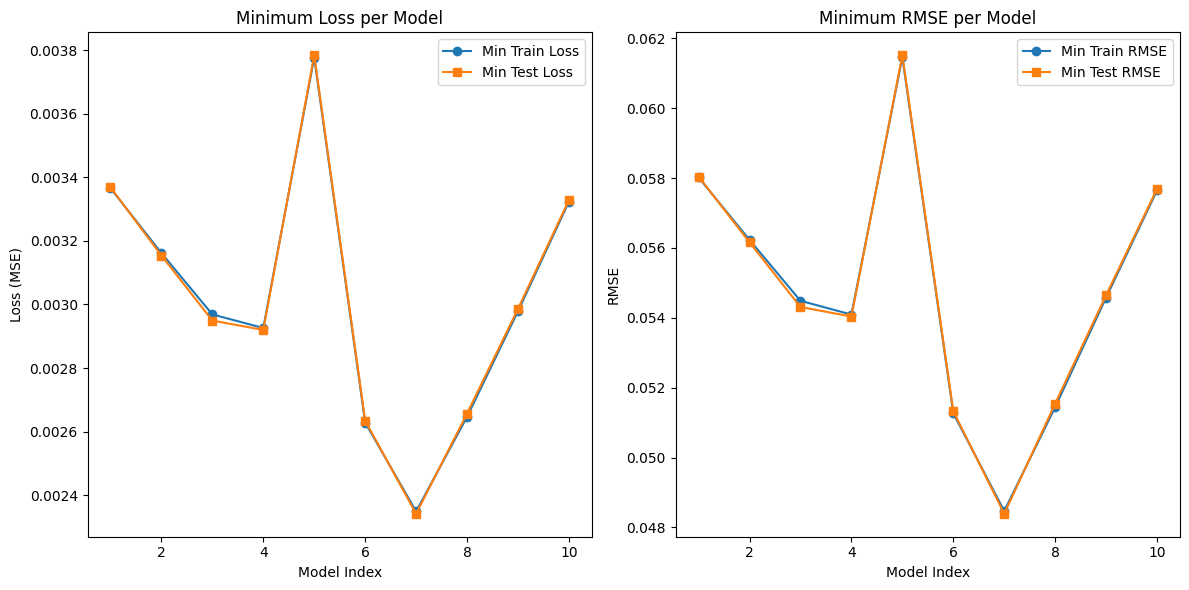

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Collect minimum values per model
min_train_loss = [min(losses) for losses in all_train_loss]
min_test_loss  = [min(losses) for losses in all_test_loss]
min_train_rmse = [min(rmses) for rmses in all_train_rmse]
min_test_rmse  = [min(rmses) for rmses in all_test_rmse]

# ---- Plot ----
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), min_train_loss, marker='o', label="Min Train Loss")
plt.plot(range(1, 11), min_test_loss, marker='s', label="Min Test Loss")
plt.xlabel("Model Index")
plt.ylabel("Loss (MSE)")
plt.title("Minimum Loss per Model")
plt.legend()

# RMSE
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), min_train_rmse, marker='o', label="Min Train RMSE")
plt.plot(range(1, 11), min_test_rmse, marker='s', label="Min Test RMSE")
plt.xlabel("Model Index")
plt.ylabel("RMSE")
plt.title("Minimum RMSE per Model")
plt.legend()

plt.tight_layout()
plt.show()


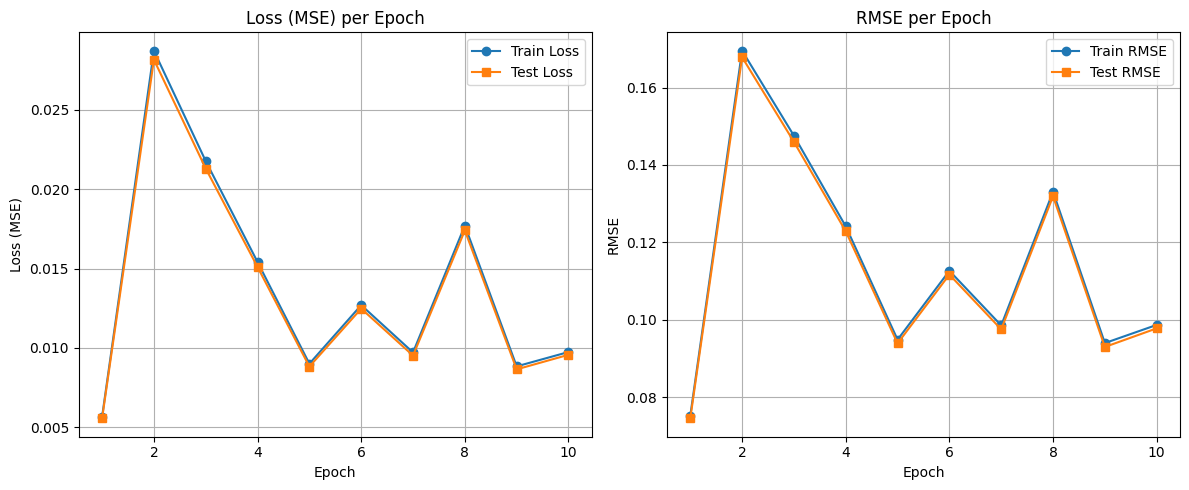

In [17]:
import matplotlib.pyplot as plt

# Pick the first model's metrics
train_loss = all_train_loss[0]
test_loss = all_test_loss[0]
train_rmse = all_train_rmse[0]
test_rmse = all_test_rmse[0]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12,5))

# Loss curve+A
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, marker='o', label="Train Loss")
plt.plot(epochs, test_loss, marker='s', label="Test Loss")
plt.title("Loss (MSE) per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# RMSE curve
plt.subplot(1,2,2)
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, test_rmse, marker='s', label="Test RMSE")
plt.title("RMSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Datasplit

In [15]:

from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Store per-model histories
all_train_loss_hist, all_test_loss_hist = [], []
all_train_rmse_hist, all_test_rmse_hist = [], []

print("\n=== Model 2 Training (Dataset Split with Scaled RMSE) ===")
subset_size = len(dataset) // 5  

for i in range(5):  # change to 10 for all subsets
    start, end = i * subset_size, (i+1) * subset_size
    subset = TensorDataset(X[start:end], y[start:end])
    loader = DataLoader(subset, batch_size=32, shuffle=True)

    model_train_losses, model_test_losses = [], []
    model_train_rmse, model_test_rmse = [], []

    print(f"\n--- Subset {i+1} ---")
    for epoch2 in range(20):  
        model.train()
        running_train_loss = 0.0

        for xb, yb in loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(loader)

        model.eval()
        with torch.no_grad():
            preds = model(X[start:end]).detach().cpu().numpy()
            true = y[start:end].detach().cpu().numpy()

            train_preds, train_targets = [], []
            for xb, yb in loader:
                p = model(xb).detach().cpu().numpy()
                t = yb.detach().cpu().numpy()
                train_preds.append(p)
                train_targets.append(t)
            train_preds = np.vstack(train_preds)
            train_targets = np.vstack(train_targets)

            train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
            test_loss = mean_squared_error(true, preds)
            test_rmse = np.sqrt(test_loss)

        print(f"Epoch {epoch2+1}: "
              f"Train Loss={avg_train_loss:.4e}, Test Loss={test_loss:.4e}, "
              f"Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

        # store epoch history for this model
        model_train_losses.append(avg_train_loss)
        model_test_losses.append(test_loss)
        model_train_rmse.append(train_rmse)
        model_test_rmse.append(test_rmse)

    # save histories for all models
    all_train_loss_hist.append(model_train_losses)
    all_test_loss_hist.append(model_test_losses)
    all_train_rmse_hist.append(model_train_rmse)
    all_test_rmse_hist.append(model_test_rmse)


# ---- Collect minimum values per model ----
min_train_losses = [min(losses) for losses in all_train_loss_hist]
min_test_losses  = [min(losses) for losses in all_test_loss_hist]
min_train_rmse   = [min(rmses) for rmses in all_train_rmse_hist]
min_test_rmse    = [min(rmses) for rmses in all_test_rmse_hist]





=== Model 2 Training (Dataset Split with Scaled RMSE) ===

--- Subset 1 ---
Epoch 1: Train Loss=9.7638e-03, Test Loss=6.4001e-04, Train RMSE=0.0253, Test RMSE=0.0253
Epoch 2: Train Loss=5.9380e-03, Test Loss=4.0411e-04, Train RMSE=0.0201, Test RMSE=0.0201
Epoch 3: Train Loss=4.9913e-03, Test Loss=2.0621e-04, Train RMSE=0.0144, Test RMSE=0.0144
Epoch 4: Train Loss=4.5431e-03, Test Loss=1.5654e-04, Train RMSE=0.0125, Test RMSE=0.0125
Epoch 5: Train Loss=4.4440e-03, Test Loss=6.5702e-04, Train RMSE=0.0256, Test RMSE=0.0256
Epoch 6: Train Loss=4.3172e-03, Test Loss=6.2866e-04, Train RMSE=0.0251, Test RMSE=0.0251
Epoch 7: Train Loss=4.1161e-03, Test Loss=1.1813e-03, Train RMSE=0.0344, Test RMSE=0.0344
Epoch 8: Train Loss=4.1340e-03, Test Loss=4.6471e-04, Train RMSE=0.0216, Test RMSE=0.0216
Epoch 9: Train Loss=4.0764e-03, Test Loss=6.7355e-04, Train RMSE=0.0260, Test RMSE=0.0260
Epoch 10: Train Loss=4.0326e-03, Test Loss=8.5566e-04, Train RMSE=0.0293, Test RMSE=0.0293
Epoch 11: Train Loss=4

Epoch 10: Train Loss=7.5220e-02, Test Loss=5.0386e-02, Train RMSE=0.2245, Test RMSE=0.2245
Epoch 11: Train Loss=7.6509e-02, Test Loss=3.8910e-02, Train RMSE=0.1973, Test RMSE=0.1973
Epoch 12: Train Loss=7.3870e-02, Test Loss=1.0832e-02, Train RMSE=0.1041, Test RMSE=0.1041
Epoch 13: Train Loss=6.9789e-02, Test Loss=5.6444e-02, Train RMSE=0.2376, Test RMSE=0.2376
Epoch 14: Train Loss=7.0793e-02, Test Loss=5.4503e-02, Train RMSE=0.2335, Test RMSE=0.2335
Epoch 15: Train Loss=6.9271e-02, Test Loss=3.9637e-02, Train RMSE=0.1991, Test RMSE=0.1991
Epoch 16: Train Loss=7.3090e-02, Test Loss=4.9351e-02, Train RMSE=0.2222, Test RMSE=0.2222
Epoch 17: Train Loss=6.9668e-02, Test Loss=3.0896e-02, Train RMSE=0.1758, Test RMSE=0.1758
Epoch 18: Train Loss=7.1106e-02, Test Loss=3.5804e-02, Train RMSE=0.1892, Test RMSE=0.1892
Epoch 19: Train Loss=7.1153e-02, Test Loss=1.8104e-02, Train RMSE=0.1346, Test RMSE=0.1346
Epoch 20: Train Loss=7.2139e-02, Test Loss=3.6216e-02, Train RMSE=0.1903, Test RMSE=0.1903

In [17]:
# Print dataset size
print(f"Total rows in dataset: {len(dataset)}")

# Print split info
subset_size = len(dataset) // 5
print(f"Rows per subset: {subset_size}")

for i in range(10):  # or 5 if you’re using 5 subsets
    start, end = i * subset_size, (i+1) * subset_size
    print(f"Subset {i+1}: rows {start} to {end-1}, total = {end-start}")


Total rows in dataset: 110238
Rows per subset: 22047
Subset 1: rows 0 to 22046, total = 22047
Subset 2: rows 22047 to 44093, total = 22047
Subset 3: rows 44094 to 66140, total = 22047
Subset 4: rows 66141 to 88187, total = 22047
Subset 5: rows 88188 to 110234, total = 22047
Subset 6: rows 110235 to 132281, total = 22047
Subset 7: rows 132282 to 154328, total = 22047
Subset 8: rows 154329 to 176375, total = 22047
Subset 9: rows 176376 to 198422, total = 22047
Subset 10: rows 198423 to 220469, total = 22047


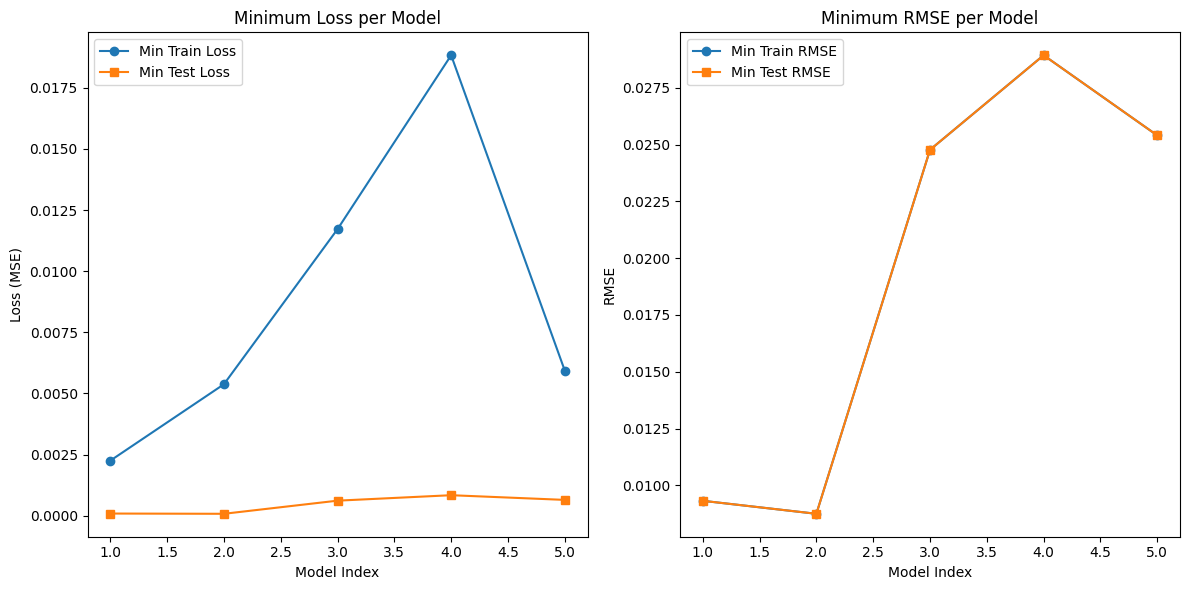

In [14]:
# ---- Collect minimum values per model ----
min_train_losses = [min(losses) for losses in all_train_loss_hist]
min_test_losses  = [min(losses) for losses in all_test_loss_hist]
min_train_rmse   = [min(rmses) for rmses in all_train_rmse_hist]
min_test_rmse    = [min(rmses) for rmses in all_test_rmse_hist]

# ---- Plot ----
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(min_train_losses)+1), min_train_losses, marker='o', label="Min Train Loss")
plt.plot(range(1, len(min_test_losses)+1), min_test_losses, marker='s', label="Min Test Loss")
plt.xlabel("Model Index")
plt.ylabel("Loss (MSE)")
plt.title("Minimum Loss per Model")
plt.legend()

# RMSE
plt.subplot(1, 2, 2)
plt.plot(range(1, len(min_train_rmse)+1), min_train_rmse, marker='o', label="Min Train RMSE")
plt.plot(range(1, len(min_test_rmse)+1), min_test_rmse, marker='s', label="Min Test RMSE")
plt.xlabel("Model Index")
plt.ylabel("RMSE")
plt.title("Minimum RMSE per Model")
plt.legend()

plt.tight_layout()
plt.show()


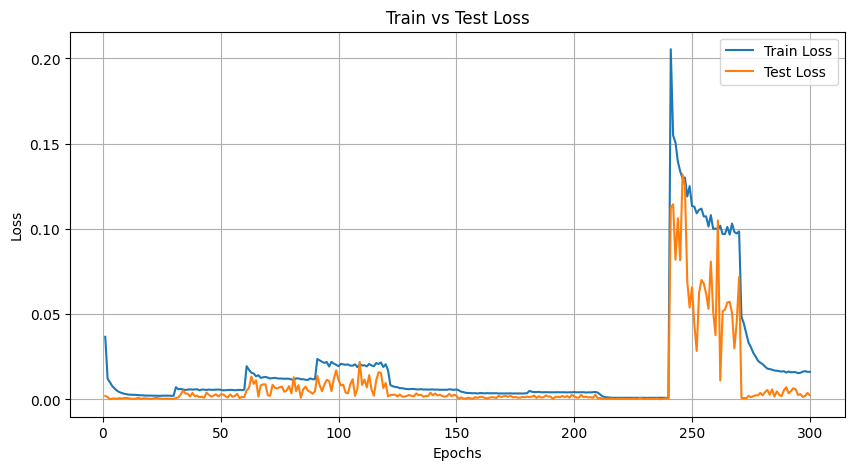

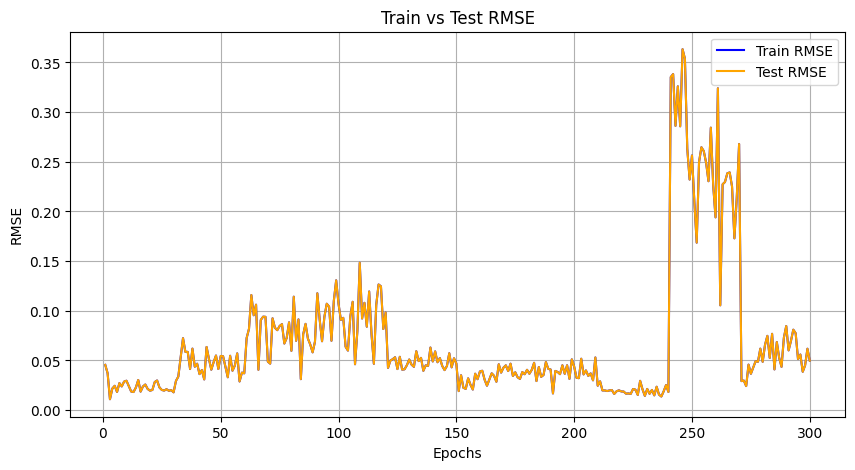

In [7]:
import matplotlib.pyplot as plt

# Define epochs for all subsets combined
epochs = list(range(1, len(all_train_losses) + 1))  # e.g., 300 if 10 subsets × 30 epochs

# --- Loss plot ---
plt.figure(figsize=(10,5))
plt.plot(epochs, all_train_losses, label="Train Loss")
plt.plot(epochs, all_test_losses, label="Test Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Train vs Test RMSE across all subsets ---
plt.figure(figsize=(10,5))
plt.plot(epochs, all_train_rmse, label="Train RMSE", color="blue")
plt.plot(epochs, all_test_rmse, label="Test RMSE", color="orange")

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np

# Initialize model
input_dim = X.shape[1]
model = StockNN(input_dim)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Train/Test split ===
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Lists for metrics ===
train_loss_list, test_loss_list = [], []
train_rmse_list, test_rmse_list = [], []

# === Training loop for 10 epochs ===
for epoch in range(10):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0
    train_preds, train_targets = [], []

    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_preds.append(preds.detach())
        train_targets.append(yb.detach())

    avg_train_loss = running_train_loss / len(train_loader)
    train_preds = torch.cat(train_preds).cpu().numpy()
    train_targets = torch.cat(train_targets).cpu().numpy()
    train_rmse = np.sqrt(np.mean((train_preds - train_targets) ** 2))

    # ---- Evaluation on Test ----
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        running_test_loss = 0.0
        for xb, yb in test_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            running_test_loss += loss.item()

            test_preds.append(preds)
            test_targets.append(yb)

        avg_test_loss = running_test_loss / len(test_loader)
        test_preds = torch.cat(test_preds).cpu().numpy()
        test_targets = torch.cat(test_targets).cpu().numpy()
        test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))

    # Save metrics
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(avg_test_loss)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    print(f"Epoch {epoch+1}/10 | "
          f"Train Loss={avg_train_loss:.6f}, Test Loss={avg_test_loss:.6f}, "
          f"Train RMSE={train_rmse:.6f}, Test RMSE={test_rmse:.6f}")


Epoch 1/10 | Train Loss=0.048532, Test Loss=0.008635, Train RMSE=0.220301, Test RMSE=0.092927
Epoch 2/10 | Train Loss=0.032780, Test Loss=0.003983, Train RMSE=0.181053, Test RMSE=0.063112
Epoch 3/10 | Train Loss=0.029578, Test Loss=0.004475, Train RMSE=0.171983, Test RMSE=0.066893
Epoch 4/10 | Train Loss=0.029580, Test Loss=0.018253, Train RMSE=0.171988, Test RMSE=0.135104
Epoch 5/10 | Train Loss=0.028577, Test Loss=0.002326, Train RMSE=0.169048, Test RMSE=0.048227
Epoch 6/10 | Train Loss=0.027507, Test Loss=0.002169, Train RMSE=0.165853, Test RMSE=0.046572
Epoch 7/10 | Train Loss=0.027309, Test Loss=0.002998, Train RMSE=0.165256, Test RMSE=0.054756
Epoch 8/10 | Train Loss=0.027134, Test Loss=0.001386, Train RMSE=0.164718, Test RMSE=0.037230
Epoch 9/10 | Train Loss=0.027697, Test Loss=0.003123, Train RMSE=0.166426, Test RMSE=0.055880
Epoch 10/10 | Train Loss=0.027301, Test Loss=0.003098, Train RMSE=0.165231, Test RMSE=0.055663


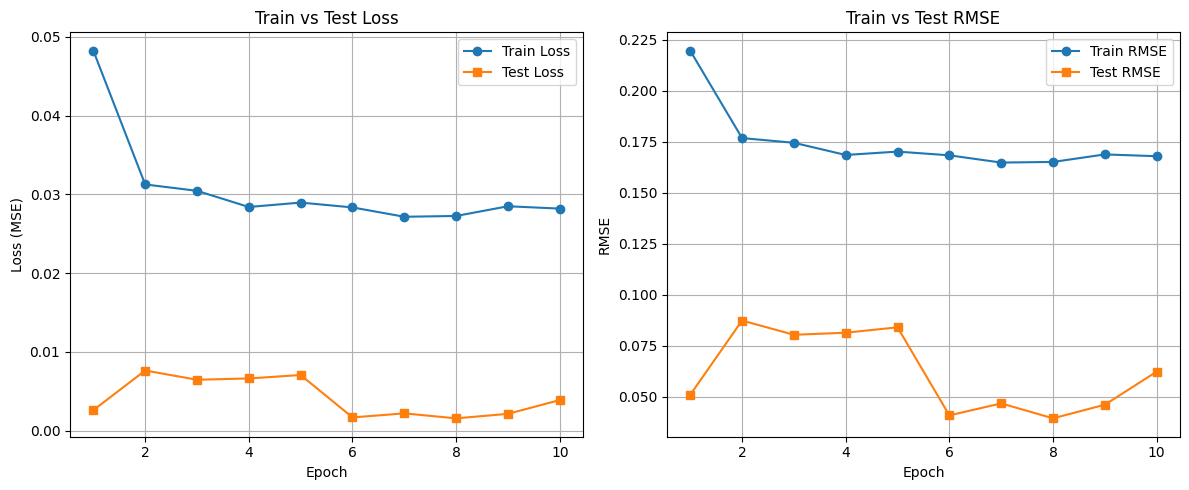

In [31]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list, marker='o', label="Train Loss")
plt.plot(epochs, test_loss_list, marker='s', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# RMSE curve
plt.subplot(1,2,2)
plt.plot(epochs, train_rmse_list, marker='o', label="Train RMSE")
plt.plot(epochs, test_rmse_list, marker='s', label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()